### k-nächste Nachbarn auf dem Ames Housing Price Data Set

Einmalige Installation notwendiger Pakete wird in VL 3 beschrieben. 

#### Versionsgeschichte

- 1.0 21.05.2023 Willi Hahn Initialversion
- 1.3 21.10.2023 Willi Hahn Datenvorbereitung nach Ames EDA handcrafted.ipynb ausgelagert
    

In [1]:
# notwendige Bibliotheken importieren und konfigurieren
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #Plot Bibliothek
import seaborn as sns #importing Seaborn's for plots
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from timeit import default_timer as timer

import math
import bokeh   # graphische, interaktive Plots
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, LassoSelectTool, Plot, WheelZoomTool, BoxZoomTool, ResetTool
output_notebook(resources=None, verbose=True, hide_banner=True)


# logging einrichten. (Alle Standard handler werden ausgeschaltet)
scriptname='Ames kNN.ipynb'
logtext="" # Variable zum additiven Wegschreiben
import logging
logging.getLogger().removeHandler(logging.getLogger())
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s;%(levelname)s;%(message)s;",
    datefmt="%Y-%m-%d %H:%M:%S",
    encoding='utf-8',
    handlers=[logging.FileHandler("AllScripts.log", "a")]
)



In [2]:
# Daten einlesen
path = 'c:/myBox/Projekte/FHDW/python/Ames_Train_1_cleaned.csv'# für lokale Dateien
#path = 'https://github.com/WilliHahn/FHDW/raw/main/Ames_Train_1_cleaned.csv'
df = pd.read_csv(path, sep=',') 

# Originaldaten einlesen für Unersuchungen der Vorhersagen
path = 'c:/myBox/Projekte/FHDW/Kurs DAML/Daten/AmesHousing.csv' # für lokale Dateien
#path = 'https://github.com/WilliHahn/FHDW/raw/main/Ames_Train_1_cleaned.csv'
df_org= pd.read_csv(path, sep=',') 


In [3]:
# Trainings- und Testdaten aufteilen
TESTANTEIL = 0.25 # Split der Test- und Trainingsdaten
# Trennung von unabhängigen Variablen und abhängiger Zielvariable
print (df.shape)
y = df['SalePrice']
x = df.drop(['SalePrice'], axis = 1)
#x.head().T
#y.head().T
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TESTANTEIL, random_state=4711)
dfx_test = pd.DataFrame(data=x_test, columns=x.columns) # Hilfe, um unskalierte Daten später in Bezug auf OrderNo zu zeigen
x_test.drop(columns=['Order'], inplace=True, axis=1) # jetzt erst eindeutigen Primärschlüssel entfernen
x_train.drop(columns=['Order'], inplace=True, axis=1) # jetzt erst eindeutigen Primärschlüssel entfernen
# und prüfen durch ansehen
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
#print (dfx_test.info(verbose=True))


## Datenvorbereitung : Variablen skalieren
SCALER = StandardScaler()
#SCALER = MinMaxScaler() # Einkommentieren für den Test des MinMax Scalers

# Kommentieren Sie folgende Zeilen aus für einen Test ohne Skalierung der Variablen
x_train = SCALER.fit_transform(x_train)
x_test = SCALER.transform(x_test)



(2690, 29)
(2017, 27)
(2017,)
(673, 27)
(673,)


In [4]:
# Modellerstellung 

K_PARAM = 3 # Anzahl Nachbarn für die k-NN Vorhersage
METRIC = 'euclidean' # cosine oder euclidean Metrik für die Abstandsberechnung der Nachbarn
N_JOBS=-1 # int, default=None, -1 means using all processors.
WEIGHTS='uniform' # weights{‘uniform’, ‘distance’} or callable, default=’uniform’

classifier = KNeighborsRegressor(n_neighbors=K_PARAM, metric=METRIC, n_jobs=N_JOBS, weights=WEIGHTS)
classifier.fit(x_train, y_train)
y_predtest = classifier.predict(x_test)
y_predtrain = classifier.predict(x_train)

df_comparison = pd.DataFrame({"Actual":y_test,"Predicted":y_predtest})

mae = mean_absolute_error(y_test, y_predtest)
print("MAE =", mae)
rmse = mean_squared_error(y_test,y_predtest, squared=False) # squared=True gibt MSE zurück
print("RMSE",rmse)
r2 = r2_score(y_test,y_predtest)
print('Model Score R2: ', r2)
adjusted_r2 = 1 - (1-r2)*(len(y_predtest)-1)/(len(y_predtest)-x_test.shape[1]-1)
print('Model Score R2 Adjusted: ', adjusted_r2)

logging.info(scriptname + '; Standard scaled; Data Frame: ' +str(df.shape[0])+ "; "+ str(df.shape[1])+ ";"+ f'{TESTANTEIL:9.2f}'+ ";")
logging.info(scriptname + ';' + "; k=" +f'{K_PARAM:0.0f}' + "; Distanz: " + METRIC + "; Gewichtung: " + 
             WEIGHTS + ";" )
logging.info(scriptname + '; MAE=' + f'{mae:9.0f}' + "; RMSE=" + f'{rmse:9.0f}'+ "; R2=" + f'{r2:9.4f}'+ "; R2 adj.="+ 
             f'{adjusted_r2:9.4f}'+ ";")


MAE = 20901.394254581475
RMSE 30322.292278255034
Model Score R2:  0.8288918289669092
Model Score R2 Adjusted:  0.8217291613422681


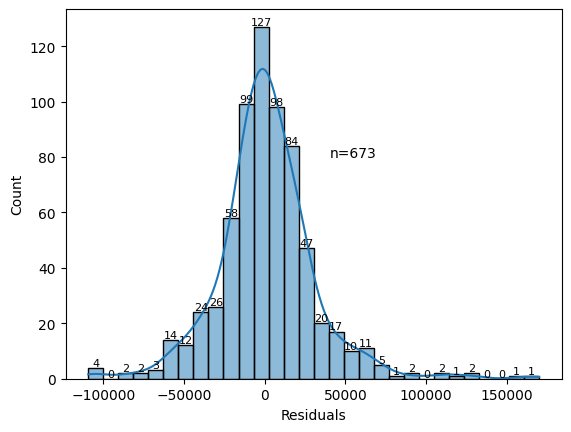

In [5]:
# Sind die die Residuen zwischen wirklichen und vorhergesagten Verkaufspreisen normalverteilt?
residuals = y_test - y_predtest
y = sns.histplot(residuals, bins=30, stat='count', element="bars", kde=True)
_ = plt.text(40000,80,"n=" + str (df_comparison.shape[0]),color='black')
_ = y.bar_label(y.containers[1], fontsize = 8)
_ = plt.xlabel('Residuals')
#plt.scatter(y=residuals, x=data['x'])
#plt.ylabel('Residuals')
#plt.xlabel('Independent variable x')
plt.show()

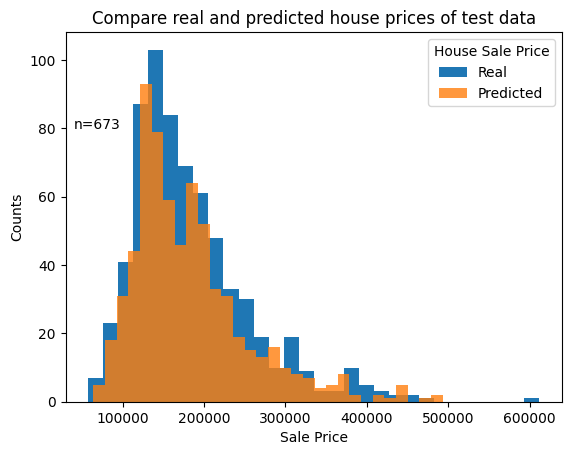

In [6]:
# Vergleich der Verteilungen für wirklichen und vorhergesagten Verkaufspreisen
fig, axes = plt.subplots(1)
plt.rcParams["figure.autolayout"] = True
_ = plt.hist(df_comparison['Actual'],bins=30)
_ = plt.xlabel('Sale Price');
_ = plt.text(40000,80,"n=" + str (df_comparison.shape[0]),color='black')
_ = plt.hist(df_comparison['Predicted'],bins=30, alpha=.8)
_ = plt.xlabel('Sale Price');
_ = plt.ylabel('Counts');
_ = plt.title('Compare real and predicted house prices of test data');
_ = plt.legend(title='House Sale Price', loc='upper right', labels=['Real', 'Predicted'])

plt.show()


In [7]:
# Scatterplot für wahre Hauspreise gegen Vorhersagen, mit tool tips

output_notebook(resources=None, verbose=True, hide_banner=True)

df_tip=pd.concat([df_comparison,dfx_test], axis=1, join='inner') 
df_tip['Order'] = dfx_test['Order'].astype('int64')

source = ColumnDataSource(df_tip)

hover = HoverTool(
        tooltips=[
            ("OrderNo", "@Order")
             , ("Sale Price Actual", "@Actual{0}")
             , ("Sale Price Predicted", "@Predicted{0}")
             , ("House Age", "@HouseAge{0}")
             , ("Remodel Age", "@RemodelAge{0}")
             , ("Lot Area", "@{Lot Area}{0}")
             , ("Living Area", "@{Gr Liv Area}{0}")
             , ("Bathrooms", "@TotalBathrooms{0.0}")
             , ("NeighborhoodClass", "@NeighborhoodClass")
        ]
    )

p = figure(width=800, height=400, tools=[hover],
           title="Actual vs predicted Sale Price (see tool tip)", x_range=(0, 700000), 
               y_range=(0, 700000),
           toolbar_location="right", toolbar_sticky=False)
p.add_tools(WheelZoomTool(), BoxZoomTool(), ResetTool())
p.xaxis.axis_label = 'Actual Sale Price'
p.yaxis.axis_label = 'Predicted Sale Price'
p.left[0].formatter.use_scientific = False
p.below[0].formatter.use_scientific = False
_ = p.circle('Actual', 'Predicted', size=10, source=source)
_ = show(p)